## Recap:
#### 1. Overview of Plan
**Guiding Question for Doing EDA (purpose):**

After accounting for the legal reason for the stop (moving violation, DUI, etc), *what other factors (gender, location,hour of day, etc) can statistically explain the choice to conduct a search?*

e.g: 
* I will control for the "reason_for_stop" by grouping, then let's say I did some analysis to see if gender is associated with getting a search or not
* I find that male has a higher search rate compared to females in the group "moving violation" 
* ==> even when the reason for being stopped is the same, analysis shows that gender is associated w/ higher likelihood of being searched

#### 2. The Progress (EDA.ipynb)
* after reviewing the data given and briefly analyzing w/ descriptive stats: 
    * I have chosen 5 features that I believe would be good features to statistically explain the choice to whether or not a search will occur

**My Chosen 5 Features:** ['time', 'district', 'subject_age', 'subject_race', 'subject_sex']
___

## Now: 
explore these chosen features with

**1. univariate analysis** 
* understand the features by themselves (ex. their distributions)

**2. controlled bivariated analysis** (b/w feature and "search_conducted" -- the target variable)
* control for the "reason_for_stop" (filtering/grouping)
* find possible relationships and associations to answer answer guiding question
___

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
sf_stops = pd.read_csv("sf_stops_clean.csv")
print("Shape of df:", sf_stops.shape)
display(sf_stops.head(10))

Shape of df: (902615, 8)


,raw_row_number,time,district,subject_age,subject_race,subject_sex,search_conducted,reason_for_stop
0,869921,00:01:00,NaN,NaN,asian/pacific islander,female,False,Mechanical or Non-Moving Violation (V.C.)
1,869922,00:01:00,NaN,NaN,black,male,False,Mechanical or Non-Moving Violation (V.C.)
2,869923,00:15:00,NaN,NaN,hispanic,male,False,Mechanical or Non-Moving Violation (V.C.)
3,869924,00:18:00,NaN,NaN,hispanic,male,False,Mechanical or Non-Moving Violation (V.C.)
4,869925,00:19:00,NaN,NaN,white,male,False,Mechanical or Non-Moving Violation (V.C.)
5,869926,00:30:00,NaN,NaN,black,male,False,Mechanical or Non-Moving Violation (V.C.)
6,869927,00:30:00,NaN,NaN,hispanic,male,False,Moving Violation
7,869928,00:35:00,NaN,NaN,black,female,False,Mechanical or Non-Moving Violation (V.C.)
8,869929,01:00:00,NaN,NaN,black,male,False,Mechanical or Non-Moving Violation (V.C.)
9,869930,01:00:00,NaN,NaN,white,female,False,Moving Violation


___
## Before Visualizing: Clean the Data 
### 1. "time" column
* engineer new feature "hour_of_day" from "time" column

In [26]:
# conver "time" column to datetime objects
sf_stops["time"] = pd.to_datetime(sf_stops["time"], format="%H:%M:%S", errors="coerce")

# extract the hour & store it in new column
sf_stops["hour_of_day"] = sf_stops["time"].dt.hour

sf_stops.head()

,raw_row_number,time,district,subject_age,subject_race,subject_sex,search_conducted,reason_for_stop,hour_of_day
0,869921,1900-01-01 00:01:00,NaN,NaN,asian/pacific islander,female,False,Mechanical or Non-Moving Violation (V.C.),0.0
1,869922,1900-01-01 00:01:00,NaN,NaN,black,male,False,Mechanical or Non-Moving Violation (V.C.),0.0
2,869923,1900-01-01 00:15:00,NaN,NaN,hispanic,male,False,Mechanical or Non-Moving Violation (V.C.),0.0
3,869924,1900-01-01 00:18:00,NaN,NaN,hispanic,male,False,Mechanical or Non-Moving Violation (V.C.),0.0
4,869925,1900-01-01 00:19:00,NaN,NaN,white,male,False,Mechanical or Non-Moving Violation (V.C.),0.0


### 2. NaNs

In [27]:
print("Columns w/ NaNs:", "\n" )
print(sf_stops.isna().any())

Columns w/ NaNs: 

raw_row_number      False
time                 True
district             True
subject_age          True
subject_race        False
subject_sex         False
search_conducted    False
reason_for_stop      True
hour_of_day          True
dtype: bool


In [28]:
# check if missing values make up a significant portion of the data 
# -> if not, drop rows w/ missing values

print("Percentage of missing values PER column:", "\n")
print((sf_stops.isna().mean() * 100))

Percentage of missing values PER column: 

raw_row_number      0.000000
time                0.003878
district            5.770234
subject_age         6.507869
subject_race        0.000000
subject_sex         0.000000
search_conducted    0.000000
reason_for_stop     0.244733
hour_of_day         0.003878
dtype: float64


* seeing that total NaNs make up around 12% of the data, I will NOT be dropping ALL the NaNs at this step (sf_stops.dropna())
    * because 12% is a big portion of the data
* instead...
    * **at this step:** drop NaNs for "time" and "reason_for_stop" since their NaNs make up a very small amount
    * **about to plot "district" or "subject_age:** drop NaNs ONLY for that plot


In [29]:
# drop NaNs for "hour_of_day" and "reason_for_stop" since their NaNs make up a very small amount

sf_stops_clean = sf_stops.dropna(subset=["hour_of_day", "reason_for_stop"])

print("Shape of cleaned df:", sf_stops_clean.shape, "\n")

print("Columns w/ NaNs:", "\n" )
print(sf_stops_clean.isna().any())

Shape of cleaned df: (900371, 9) 

Columns w/ NaNs: 

raw_row_number      False
time                False
district             True
subject_age          True
subject_race        False
subject_sex         False
search_conducted    False
reason_for_stop     False
hour_of_day         False
dtype: bool


___
## Visuals and Insights
### 1. Correlation Heatmap
* can *only* used on the numerical features ("hour_of_day", "subject_age", "subject_sex" -- after converting to numerics)
* displays possible **linear** relationship between multiple variables w/ Pearson's correlation coefficients 
    * +1: perfect positive linear correlation
    * 0: no linear correlation
    * -1: perfect negative linear correlation

In [36]:
# convert "search_conducted" column to numeric (0's and 1's)
sf_stops_clean["search_conducted_numeric"] = sf_stops_clean["search_conducted"].astype(int)

# convert "subject_sex" column to numeric 
# (0's and 1's where male = 1, female = 0)
sf_stops_clean["sex_numeric"] = sf_stops_clean["subject_sex"].map({"male": 1, "female": 0})

#sf_stops_clean.head()

numeric_cols = ["hour_of_day", "subject_age", "sex_numeric", "search_conducted_numeric"]
numeric_df = sf_stops_clean[numeric_cols].dropna()

numeric_df.head()

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_65709/2831854510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_stops_clean["search_conducted_numeric"] = sf_stops_clean["search_conducted"].astype(int)
/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_65709/2831854510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_stops_clean["sex_numeric"] = sf_stops_clean["subject_sex"].map({"male": 1, "female": 0})


,hour_of_day,subject_age,sex_numeric,search_conducted_numeric
33092,10.0,56.0,1,0
33093,10.0,32.0,1,0
33094,10.0,57.0,0,0
33095,10.0,31.0,1,0
33096,10.0,37.0,0,0


Text(0.5, 1.0, 'Correlation Heatmap of Numeric Features')

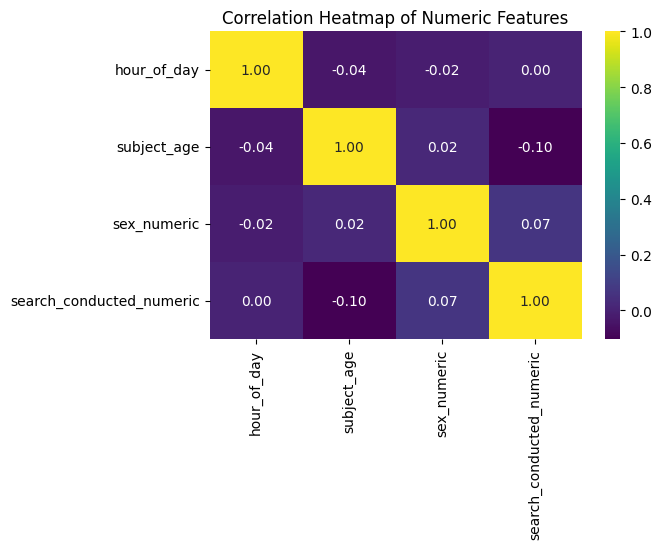

In [45]:
# correlation matrix
corr_matrix = numeric_df.corr()

# plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, 
            annot = True, 
            cmap = "viridis",
            fmt = ".2f")
plt.title("Correlation Heatmap of Numeric Features")

#### Quick Analysis of Heatmap:
* the linear relationship between the numerical variables/features are weak and nearly non-existent (coef = around 0)
* although there is no *linear* relationship between these features and "search_conducted," this is not a conclusive trend as further plots such as boxplots/scatterplots can reveal other patterns about their relationship
___

### 2. Univariate Analysis
due to time constraint and wanting to focus more on bivariate analysis:
* only do univariate analysis on "hour_of_day", "subject_age", "district", "reason_for_stop" (control variable), and "search_conducted" (target variable)

In [48]:
sf_stops_clean.columns

Index(['raw_row_number', 'time', 'district', 'subject_age', 'subject_race',
       'subject_sex', 'search_conducted', 'reason_for_stop', 'hour_of_day',
       'search_conducted_numeric', 'sex_numeric'],
      dtype='object')

#### a. "hour_of_day"

Text(0, 0.5, 'Number of Stops')

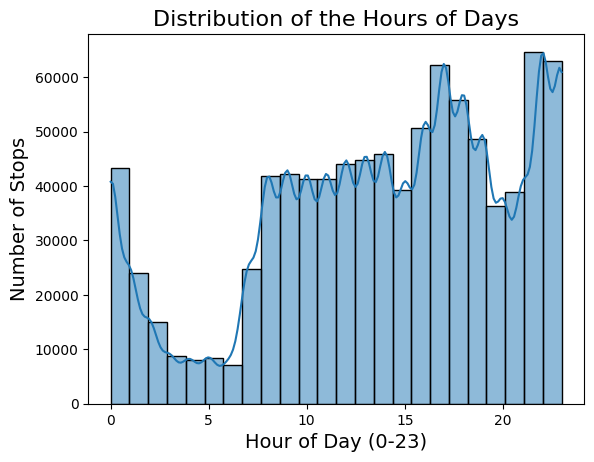

In [57]:
sns.histplot(data = sf_stops_clean, x = "hour_of_day", bins = 24, kde = True)
plt.title("Distribution of the Hours of Days", fontsize=16)
plt.xlabel("Hour of Day (0-23)", fontsize=14)
plt.ylabel("Number of Stops", fontsize=14)

#### Quick Analysis of Histogram of Hour of Day:
* lowest period for stops is in the early morning around 2AM to 5AM
* stops begin to rise and remain constant around 6AM to 3PM (16:00)
* stops peak at around 3PM (16:00) to 7PM (19:00) and 9PM (21:00) to 12PM (00:00)
    * both of these peaks having around 60,000 stops
* stops mostly occur not only around peak hours (morning and early evening), but also at the beginning of the night
___

#### b. "subject_age"

Text(0.5, 0, 'Subject Age (10-100)')

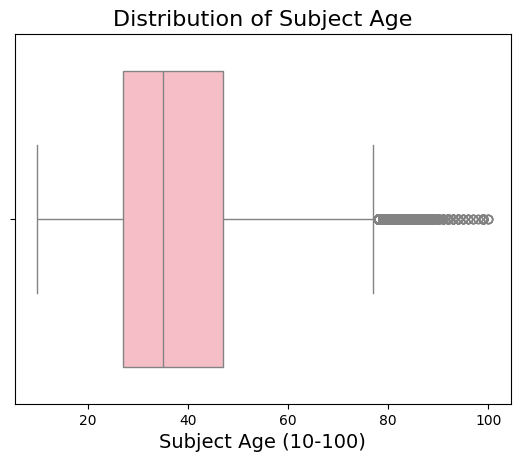

In [68]:
sns.boxplot(data = sf_stops_clean.dropna(subset=["subject_age"]), x = "subject_age", color = "lightpink")
plt.title("Distribution of Subject Age", fontsize=16)
plt.xlabel("Subject Age (10-100)", fontsize=14)

#### Quick Analysis of Boxplot for Subject Age:
* distribution is skewed right w/ middle 50% of subjects being around 23-43 years old
* the median age is around 38 years old
* stops recorded for 78+ subjects appear to be outliers
___

#### c. "district"

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_65709/1305957864.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = sf_stops_clean.dropna(subset=["district"]),


Text(0, 0.5, 'District')

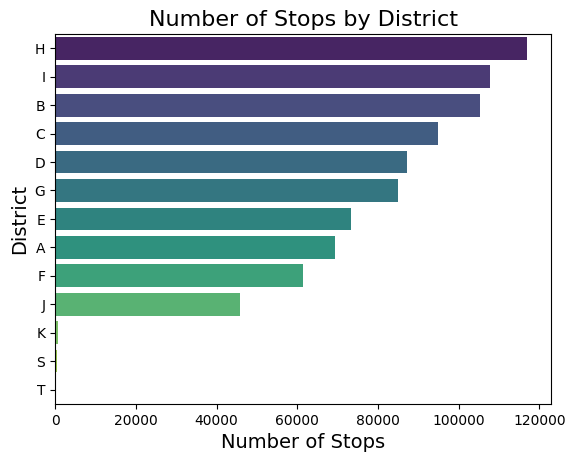

In [112]:
# horizontal bar plot
# w/ order= to sort the bars from most to least frequent
sns.countplot(data = sf_stops_clean.dropna(subset=["district"]), 
              y = "district", 
              order = sf_stops_clean["district"].value_counts().index,
              palette = "viridis")

plt.title("Number of Stops by District", fontsize=16)
plt.xlabel("Number of Stops", fontsize=14)
plt.ylabel("District", fontsize=14)

#### Quick Analysis of District Countplot:
* districts K, S, and T have almost zero stops; so small, barely register on the chart
* concentration: top 3 districts (H, I, and B), over 100,000 stops each
* district H (longest bar) has about 118,000 stops compared to district J (shortest, but still signifcant bar) has about 48,000 stops
    * district H has more than double the stops of district J, so overall plot is pretty uneven
    * noticeable drop in enforcement/stops 
* districts K, S, and T have almost zero stops; so small, barely register on the chart
    * seems like either enforcement don't really both with these districts or they are just districts that stay out of trouble
___
#### d. "reason_for_stop" (control variable)

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_65709/2789059548.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = sf_stops_clean,


Text(0, 0.5, 'Reason for Stop')

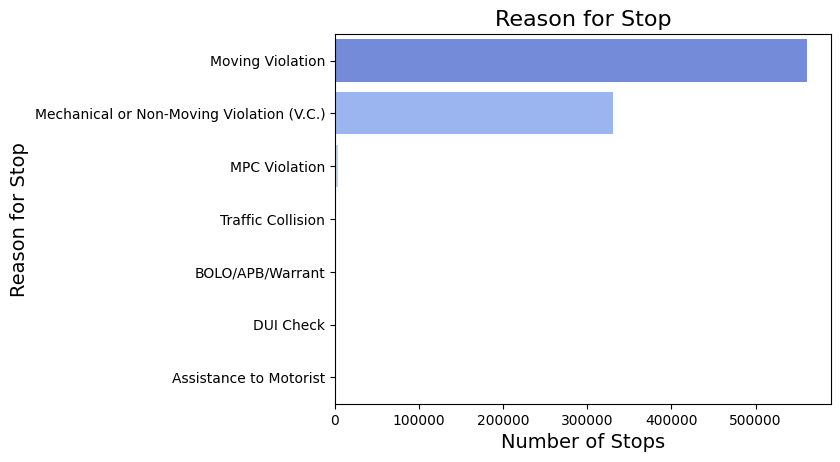

In [76]:
sns.countplot(data = sf_stops_clean, 
              y = "reason_for_stop", 
              order = sf_stops_clean["reason_for_stop"].value_counts().index,
              palette = "coolwarm")

plt.title("Reason for Stop", fontsize=16)
plt.xlabel("Number of Stops", fontsize=14)
plt.ylabel("Reason for Stop", fontsize=14)

#### Quick Analysis of Reason For Stop Countplot:
* vast majority of stops (likely >98%) fall into two categories: "Moving Violation" and "Mechanical or Non-Moving Violation (V.C)" 
* all other reasons are statistically rare
* **important finding** because for controlled bivariated analysis -> can just use these two main categories as the "control" groups

___
#### e. "search_conducted" (target variable)

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_65709/1201011237.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = sf_stops_clean,


Text(0, 0.5, 'Number of Stops')

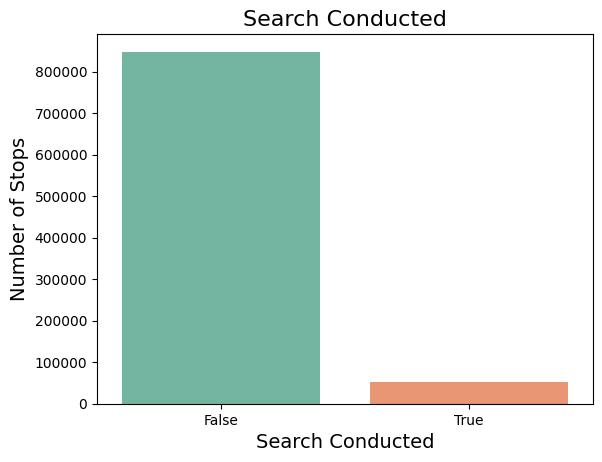

In [80]:
sns.countplot(data = sf_stops_clean, 
              x = "search_conducted",
              palette = "Set2")

plt.title("Search Conducted", fontsize=16)
plt.xlabel("Search Conducted", fontsize=14)
plt.ylabel("Number of Stops", fontsize=14)

In [81]:
# percentage of search conducted
true_search = (len(sf_stops_clean[sf_stops_clean["search_conducted"] == True]) / len(sf_stops_clean)) * 100
print("Percentage of Stops where Search was Conducted:", true_search)

Percentage of Stops where Search was Conducted: 5.780728166500254


#### Quick Analysis of Search Conducted Countplot:
* "search_conducted" is very imbalanced where searches only happen around 5.78% of all stops
* because of this imbalance, we must be careful with future modeling since a simple model (predicting False ONLY) could easily achieve a (about) 94% accuracy
___
### 3. Controlled Bivariate Analysis
**Objective:** 

to identify the true relationship between my features (hour_od_day, subject_race, etc) and search_conducted, controlling for the primary confounding variable (reason_for_stop) 

**Method:**

1. create two dataframes: one for "Moving Violation" and "Mechanical or Non-Moving Violation (V.C)" 
2. plot the search rate (as a percentage) for each of my chosen features for each of these groups

In [82]:
sf_stops_clean.columns

Index(['raw_row_number', 'time', 'district', 'subject_age', 'subject_race',
       'subject_sex', 'search_conducted', 'reason_for_stop', 'hour_of_day',
       'search_conducted_numeric', 'sex_numeric'],
      dtype='object')

#### Moving Violation
##### a. Subject Age vs Search Conducted (Moving Violations Only)

In [113]:
moving_violation_df = sf_stops_clean[sf_stops_clean["reason_for_stop"] == "Moving Violation"]
#moving_violation_df.head()

<Axes: xlabel='search_conducted', ylabel='subject_age'>

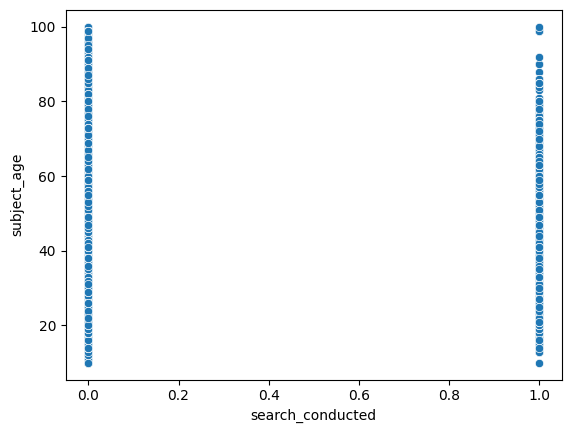

In [105]:
sns.scatterplot(data = moving_violation_df.dropna(subset=["subject_age"]), 
              x = "search_conducted",  
              y = "subject_age")

##### Target Variable Does Not Work w/ Scatterplot
* as seem above, the scatterplot is very ugly and impossible to read
* instead of making scatterplots for bivariate analysis, I will be making boxplots and barplots

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_65709/3471585601.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = moving_violation_df.dropna(subset = ["subject_age"]),


Text(0, 0.5, 'Subject Age')

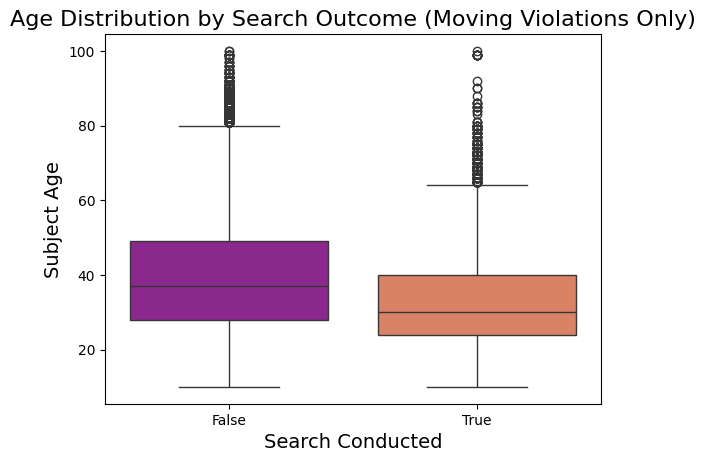

In [107]:
sns.boxplot(data = moving_violation_df.dropna(subset = ["subject_age"]), 
            x = "search_conducted",  
            y = "subject_age",
            palette = "plasma")      

plt.title("Age Distribution by Search Outcome (Moving Violations Only)", fontsize=16)
plt.xlabel("Search Conducted", fontsize=14)
plt.ylabel("Subject Age", fontsize=14)

##### Quick Analysis of Age vs. Search (Moving Violations Only):
* clear association between subject_age and the likelihood of being searched (controlling for moving violations)
* those that DON'T get searched (purple false group) tend to fall between the ages 28-50 (the box aka middle 50% of data) w/ median age around 36
* those that DO get searched (orange true group) tend to fall between the ages 24-40 w/ median age around 30
* conclusion: suggests that younger people tend to get searched more for moving violations -> good feature/predictor

___
#### b. Hour of Day vs Search Conducted (Moving Violations Only)

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_65709/3262087670.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = moving_violation_df.dropna(subset = ["hour_of_day"]),


Text(0, 0.5, 'Hour of Day')

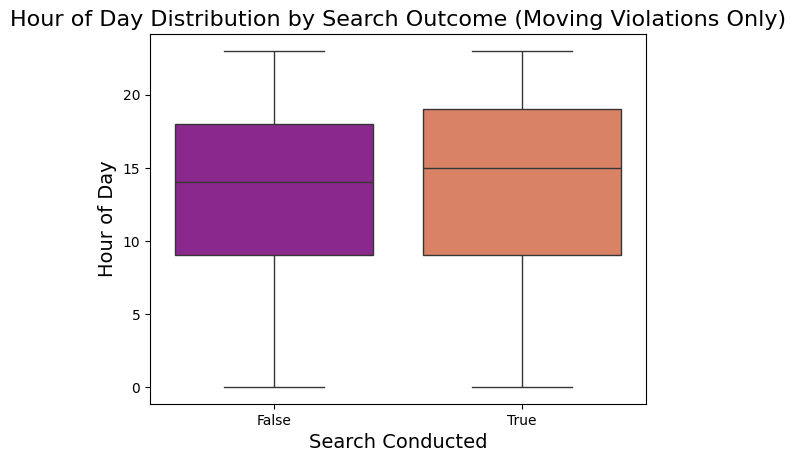

In [91]:
sns.boxplot(data = moving_violation_df.dropna(subset = ["hour_of_day"]), 
            x = "search_conducted",  
            y = "hour_of_day",
            palette = "plasma")      

plt.title("Hour of Day Distribution by Search Outcome (Moving Violations Only)", fontsize=16)
plt.xlabel("Search Conducted", fontsize=14)
plt.ylabel("Hour of Day", fontsize=14)

##### Quick Analysis of Hour of Day vs. Search (Moving Violations Only)
* plot shows no clear association between the hour_of_day and the search_conducted outcome
* unlike the subject_age plot, the distributions for the both groups are nearly identical
    * median hour for both groups is very close (around 14:00-15:00)
    * their boxes have an almost complete overlap
* conclusion: suggests that for moving violations, the time of day might not be a significant factor in the decision to conduct a search; would not be a useful predictor in a model for this specific subgroup

___

#### c. Race vs Search Rate (Moving Violations Only)

In [109]:
# calculate search rate for each category in "subject_race"
search_rate_race_df = moving_violation_df.groupby("subject_race")["search_conducted_numeric"].mean().reset_index()
search_rate_race_df = search_rate_race_df.sort_values(by = "search_conducted_numeric", ascending=False)
search_rate_race_df

,subject_race,search_conducted_numeric
1,black,0.131428
2,hispanic,0.090962
4,white,0.025859
3,other,0.025331
0,asian/pacific islander,0.016663


/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_65709/2974706118.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = search_rate_race_df,


Text(0.5, 0, 'Search Rate (as a decimal)')

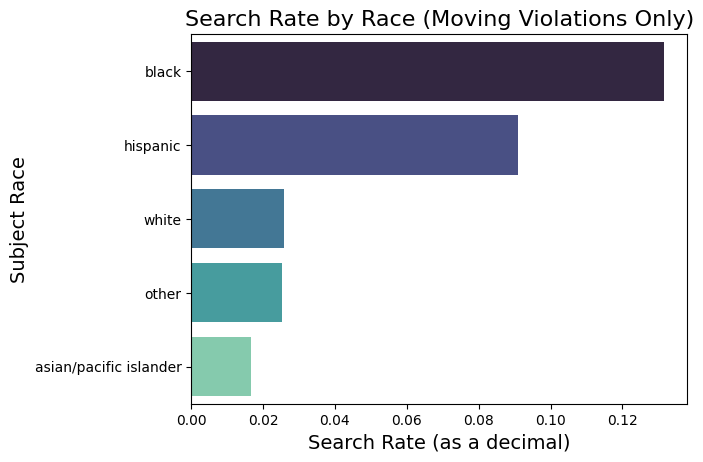

In [94]:
sns.barplot(data = search_rate_race_df, 
            y = "subject_race",                  
            x = "search_conducted_numeric",
            palette = "mako")      

plt.title("Search Rate by Race (Moving Violations Only)", fontsize=16)
plt.ylabel("Subject Race", fontsize=14)
plt.xlabel("Search Rate (as a decimal)", fontsize=14)

In [108]:
def barplot_search_rate(feature, title):
    search_rate_df = moving_violation_df.groupby(feature)["search_conducted_numeric"].mean().reset_index()
    search_rate_df = search_rate_df.sort_values(by = "search_conducted_numeric", ascending=False)
    
    sns.barplot(data = search_rate_df, 
                y = feature,                  
                x = "search_conducted_numeric",
                palette = "mako")      

    plt.title(title, fontsize = 16)
    plt.ylabel(feature.replace("_", " ").title(), fontsize = 14)
    plt.xlabel("Search Rate (as a decimal)", fontsize = 14)

##### Quick Analysis of Race vs. Search Rate (Moving Violations Only)
* drivers identified as "black" have the highest search rate about 12.5%, followed by "hispanic" drivers at 9%
* "white" (~2.5%), "other" (~2.5%), and "asian/pacific islander" (~1.7%) are all clustered in a similar, very low search rate bracket
* conclusion: strongly suggests that subject_race is a significant predictor of search outcomes, independent of the moving violation stop reason

---

#### d. Sex vs Search Conducted (Moving Violations Only)

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_65709/1145507622.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = search_rate_df,


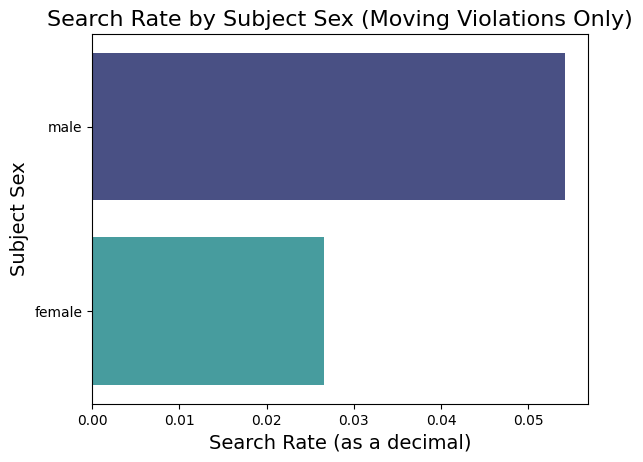

In [110]:
barplot_search_rate("subject_sex", "Search Rate by Subject Sex (Moving Violations Only)")

##### Quick Analysis of Sex vs. Search Rate (Moving Violations Only)
* male has a nearly double search rate (~5%) compared to female (~2.6%)
* conclusion: strongly suggests that subject_sex is a significant predictor of search outcomes, independent of the moving violation stop reason

---

#### e. District vs Search Conducted (Moving Violations Only)

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_65709/1145507622.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = search_rate_df,


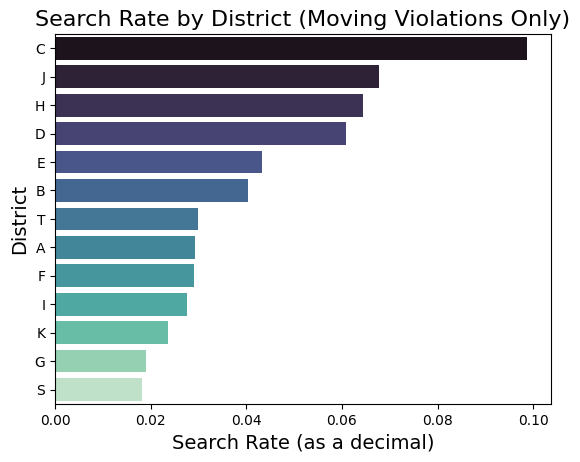

In [111]:
barplot_search_rate("district", "Search Rate by District (Moving Violations Only)")

##### Quick Analysis of District vs. Search Rate (Moving Violations Only)
* search rates are not uniform across the districts and can be grouped into distinct tiers:
    * tier 1: distric C is a significant outlier w/ highest search rate around 10%; substantially higher than any other district
    * tier 2 (medium-high): includes J, H, and D, all w/ rates b/w 6% and 7.5%
    * tier 3 (low/average): ajority of districts are clustered in a much lower bracket
        * S and G have the lowest rates at approx 2%
        * the rest (K, I, F, A, B, and E) falling in the 2.5% to 4.5% range

* **compare to "Number of Stops by District" plot from univariate analysis:**
    * this old plot showed H, I, and B had the most stops
    * new plot: distric I (2nd most stops) has one of the lowest search rates
* conclusion: 
    * high volume of stops in a district (like "I") does not necessarily mean a high rate of searches
    * suggests that the policies or practices that trigger a search may differ significantly from district to district, independent of how many stops was made
    * new plot shows strong association between district and search likelihood -> good predictor
---

## Summary and Key Takeaways:
note: I'm not able to continue the second part of the controlled bivariate analysis where I repeat everything above (exact same visuals and code) but instead for "Mechanical or Non-Moving Violation (V.C)" due to time constraint and being busy this Wednesday. I was able to spend my Monday and whole Tuesday on this and I hope the findings I have made so far will more than enough meet the specs and show some really interesting results! Thank you!

